## PDF Scraper 
### We created a pdf scraper that will loook into the yearly reports from a company and check/compile which SDG they are looking into. We visualize the data to show which was used through the years.

In [1]:
import re
from pdfminer.high_level import extract_text
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def extract_text_counts(pdf_file_path, search_patterns):
    """_summary_
    Extract text from pdf file and get the counts of the occurrence of
    each search pattern.

    Args:
        pdf_file_path (string): filepath of the pdf file.
        search_patterns (list<string/regex>): list of search patterns can be string or regular expression.
    Returns:
        Dicionary: containing the text found and their occurrence count.
    """
    
    # Initialize a dictionary to store the counts of each found phrase
    phrase_counts = {}
    
    # Extract text from the PDF
    text = extract_text(pdf_file_path)
    
    # Search for the specified patterns and update counts
    for pattern in search_patterns:
        matches = re.finditer(pattern, text)
        for match in matches:
            
            matched_phrase = match.group(0)  # Get the matched phrase
            matched_phrase = matched_phrase.upper()
            
            parts = matched_phrase.split(' ', 1)

            # Check if there's a space and at least one character after it
            if len(parts) == 2:
                prefix = 'SDG'
                rest_of_string = parts[1]
                matched_phrase = f'{prefix} {rest_of_string}'
            
            if matched_phrase not in phrase_counts:
                phrase_counts[matched_phrase] = 1
            #else:
            #    phrase_counts[matched_phrase] += 1
                
    return phrase_counts
    

In [3]:
def display_counts(phrase_counts):
    """_summary_
    Iterate through the dictionary and display the counts for each pattern.

    Args:
        phrase_counts (dictionary): contains the text found and their occurrence count.
        
    Returns:
        None
    """
    # Output the found phrases and their counts
    for pattern, counts in phrase_counts.items():
        print(f"{pattern} count: {counts}")
    

In [4]:
def custom_sort_key(target):
    """_summary_

    Args:
        target (string): text that will be given a weight for sorting

    Returns:
        float: returns the weight that will be associated with the text that was passed
    """
    
    # get the X.Y part of the targets and separate them to 2 parts
    match = re.search(r'(\d+)\.(\w+)', target)
    if match:
        num_part = match.group(1)
        alpha_part = match.group(2)    
    
    # if the 2nd part is a letter convert it to its ascii and divide that value by 1000 to ensure its always on top
    # while still being sorted among the letters. Otherwise it will convert the match to float and use as is
    if alpha_part.isalpha():
        alpha_part = ord(alpha_part) / 1000         # convert to ascii value and divide by 1000 to ensure its always on top
        num_part = float(num_part) + alpha_part     # combine them back together 
    else:
        num_part = float(match.group(0))
    
    return (num_part)

In [5]:
def plot_results(results):
    """_summary_
    Takes the results dictionary and shows a heatmap of which SDGs are being supported/used per year.

    Args:
        results (dictionary): containing the year as key and text found with their occurrence count as value
    Returns:
        None
    """
    data = results
    targets = list(set(target for year_data in data.values() for target in year_data.keys()))
    targets = sorted(targets, key=custom_sort_key)
    years = list(data.keys())

    # Create a matrix to store the data
    matrix = [[data[year].get(target, 0) for year in years] for target in targets]

    # Transpose the matrix to flip the axes
    transposed_matrix = np.transpose(matrix)
    

    # Swap the labels for x and y axes
    x_labels = targets
    y_labels = years

    fig, ax = plt.subplots(figsize=(15, 10))
    cax = ax.matshow(transposed_matrix, cmap=plt.cm.Blues)

    # Adjust tick spacing
    ax.set_xticks(np.arange(len(x_labels)))
    ax.set_yticks(np.arange(len(y_labels)))

    # Label the ticks
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)

    # Rotate the y-axis labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=80)

    plt.xlabel('Targets')  # Update the label for x-axis
    plt.ylabel('Year')     # Update the label for y-axis

    plt.title('SDG Targets Focused Each Year')

    plt.show()

In [6]:
# Dictionary that contains the paths of the reports as values and the year as keys
pdf_file_paths = {
    "2018" : "Documents/OBP-Report-EN-2018.pdf",
    "2019" : "Documents/2019-SDG-Report-FINAL_1.pdf",
    "2020" : "Documents/SDG-Report_2020_EN.pdf",
    "2021" : "Documents/SDG-Report-2021-EN.pdf",
    "2022" : "Documents/SDG Report 2022.pdf",
}

# Initialize the results dictionary that will contain the serach results per year
results = {}

# Initialize the search patterns we will use.
search_patterns = [
    r"Target (\d+\.\d+)",  # Example regular expression: "Target 1.2"
    r"Target (\d+\.[a-zA-Z]+)",  # Example regular expression: "Target 1.B"
    r"SDG (\d+\.\d+)",  # Example regular expression: "SDG 1.2"
    r"SDG (\d+\.[a-zA-Z]+)",  # Example regular expression: "SDG 1.B"
]

# Runs the extract_text_counts() for each year and storing them in results
for key, pdf_file_path in pdf_file_paths.items():
    phrase_counts = extract_text_counts(pdf_file_path= pdf_file_path, search_patterns=search_patterns)
    results[key] = phrase_counts


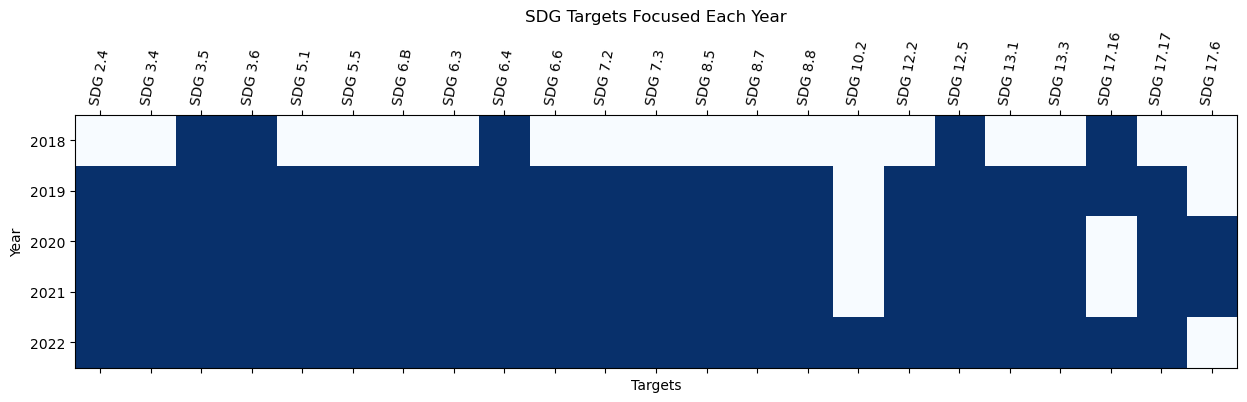

In [7]:
#plots the results    
plot_results(results=results)